<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Pure-Premium-Modelling-:-Tweedie-GLM" data-toc-modified-id="Pure-Premium-Modelling-:-Tweedie-GLM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pure Premium Modelling : Tweedie GLM</a></span></li><li><span><a href="#Modelling:-Product-of-Frequency-and-Severity-Modelling" data-toc-modified-id="Modelling:-Product-of-Frequency-and-Severity-Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling: Product of Frequency and Severity Modelling</a></span></li><li><span><a href="#Lorentz-Curves" data-toc-modified-id="Lorentz-Curves-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Lorentz Curves</a></span></li></ul></div>

# Load the libraries

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import sklearn
import scipy
import matplotlib.pyplot as plt
sns.set()

import json
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor, GammaRegressor, TweedieRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_tweedie_deviance
from sklearn.metrics import auc

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly
%load_ext watermark
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
pandas   1.1.0
autopep8 1.5.2
json     2.0.9
seaborn  0.11.0
numpy    1.18.4
joblib   0.16.0
sklearn  0.23.1
scipy    1.4.1



# Load the data

In [2]:
df = pd.read_csv('../data/processed/clean_data.csv.zip', compression='zip')
print(df.shape)
df.head(2).append(df.tail(2))

(100000, 15)


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
1,0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
99998,0,0.90,C,7,9,44,50,B1,Regular,191,R24,0.0,0.0,0.0,0.0
99999,0,0.90,E,4,12,53,50,B1,Regular,4116,R24,0.0,0.0,0.0,0.0


In [3]:
X = scipy.sparse.load_npz("../data/processed/X.npz")

In [4]:
df.head(2)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
1,0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0


In [5]:
np.array(X[0].todense())[0][-5:] # last elements of first row

array([ 0.        ,  1.        ,  0.        ,  0.69864446, 50.        ])

In [6]:
with open("../data/processed/features.json") as fi:
    json_features = json.load(fi)

In [7]:
json_features.keys()

dict_keys(['cols_ohe_before', 'cols_kbin', 'cols_log_scale', 'cols_pass', 'feature_names_before', 'feature_names_after', 'desc'])

# Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=SEED)

target = ['Frequency']

y_train = df_train[target].to_numpy().ravel()
y_test = df_test[target].to_numpy().ravel()

df_train.shape, df_test.shape, X_train.shape, X_test.shape

((75000, 15), (25000, 15), (75000, 71), (25000, 71))

# Pure Premium Modelling : Tweedie GLM

In [10]:
from sklearn.linear_model import PoissonRegressor, GammaRegressor, TweedieRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_tweedie_deviance

In [11]:
# TweedieRegressor?

In [12]:
glm_twd = TweedieRegressor(power=1.9, alpha=.1, max_iter=10_000)

glm_twd.fit(X_train, df_train["PurePremium"],
                     sample_weight=df_train["Exposure"])

TweedieRegressor(alpha=0.1, max_iter=10000, power=1.9)

In [13]:
tr_preds = glm_twd.predict(X_train)
tx_preds = glm_twd.predict(X_test)

,train,test
D2,0.020186,0.013533
mean_absolute_error,182.982035,179.520763
mean_squared_error,142995.523138,69103.013696


# Modelling: Product of Frequency and Severity Modelling

In [14]:
# freq model: possion
glm_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
glm_freq.fit(X_train, df_train["Frequency"],
             sample_weight=df_train["Exposure"])

tr_preds_freq = glm_freq.predict(X_train)
tx_preds_freq = glm_freq.predict(X_test)

In [15]:
# severity model: gamma
mask_train = (df_train["ClaimAmount"] > 0).to_numpy().ravel()
mask_test = (df_test["ClaimAmount"] > 0).to_numpy().ravel()

glm_sev = GammaRegressor(alpha=10., max_iter=10_000)

glm_sev.fit(
    X_train[mask_train],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

tr_preds_sev = glm_sev.predict(X_train)
tx_preds_sev = glm_sev.predict(X_test)

In [16]:
# product of prediction of freq and severity

tr_preds = tr_preds_freq * tr_preds_sev
tx_preds  = tx_preds_freq * tx_preds_sev

# Lorentz Curves

Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py


To compare the models, we can plot the Lorentz curve.
- For each model, the policyholders are ranked from safest to riskiest and the fraction of observed total cumulated claims is plotted on the y axis.

- The Gini coefficient (based on the area under the curve) can be used as a model selection metric.
- The gini coefficient metric does not reflect the ability of the models to make accurate predictions in terms of absolute value of total claim amounts but only in terms of relative amounts as a ranking metric.

- Both models are able to rank policyholders by risky-ness significantly better than chance although they are also both far from perfect due to the natural difficulty of the prediction problem from few features.

- Note that the Gini index only characterize the ranking performance of the model but not its calibration: any monotonic transformation of the predictions leaves the Gini index of the model unchanged.

- Finally one should highlight that the Compound Poisson Gamma model that is directly fit on the pure premium is operationally simpler to develop and maintain as it consists in a single scikit-learn estimator instead of a pair of models, each with its own set of hyperparameters.



In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

In [24]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount

In [25]:
y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_twd.predict(X_test)

[]

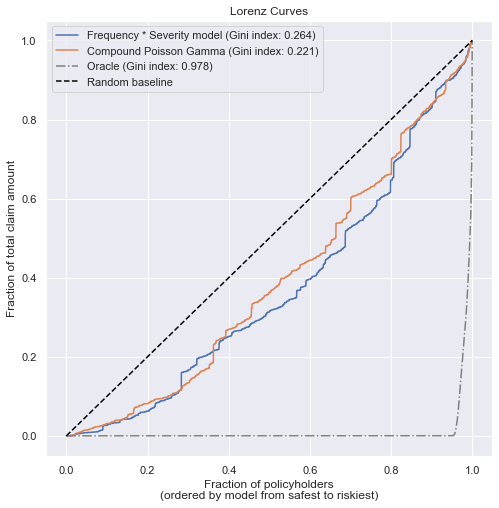

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

for label, y_pred in [("Frequency * Severity model", y_pred_product),
                      ("Compound Poisson Gamma", y_pred_total)]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"])
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"])
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray",
        label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black",
        label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel=('Fraction of policyholders\n'
            '(ordered by model from safest to riskiest)'),
    ylabel='Fraction of total claim amount'
)
ax.legend(loc="upper left")
plt.plot()